# Import package

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
%load_ext autoreload
%autoreload 2

# Setup environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load model

In [4]:
from trainer.supervised.baseline import BaselineTrainer
model = BaselineTrainer()
max_epoches = model.get_max_epoches()

>> Load from data frame


Using cache found in /home/kientiet/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master




>> Running with 1cycle scheduler


In [5]:
for name, p in model.encoder.named_parameters():
    print(name)

encoder.0.weight
encoder.1.weight
encoder.1.bias
encoder.4.0.conv1.weight
encoder.4.0.bn1.weight
encoder.4.0.bn1.bias
encoder.4.0.conv2.weight
encoder.4.0.bn2.weight
encoder.4.0.bn2.bias
encoder.4.0.conv3.weight
encoder.4.0.bn3.weight
encoder.4.0.bn3.bias
encoder.4.0.downsample.0.weight
encoder.4.0.downsample.1.weight
encoder.4.0.downsample.1.bias
encoder.4.1.conv1.weight
encoder.4.1.bn1.weight
encoder.4.1.bn1.bias
encoder.4.1.conv2.weight
encoder.4.1.bn2.weight
encoder.4.1.bn2.bias
encoder.4.1.conv3.weight
encoder.4.1.bn3.weight
encoder.4.1.bn3.bias
encoder.4.2.conv1.weight
encoder.4.2.bn1.weight
encoder.4.2.bn1.bias
encoder.4.2.conv2.weight
encoder.4.2.bn2.weight
encoder.4.2.bn2.bias
encoder.4.2.conv3.weight
encoder.4.2.bn3.weight
encoder.4.2.bn3.bias
encoder.5.0.conv1.weight
encoder.5.0.bn1.weight
encoder.5.0.bn1.bias
encoder.5.0.conv2.weight
encoder.5.0.bn2.weight
encoder.5.0.bn2.bias
encoder.5.0.conv3.weight
encoder.5.0.bn3.weight
encoder.5.0.bn3.bias
encoder.5.0.downsample.0.weig

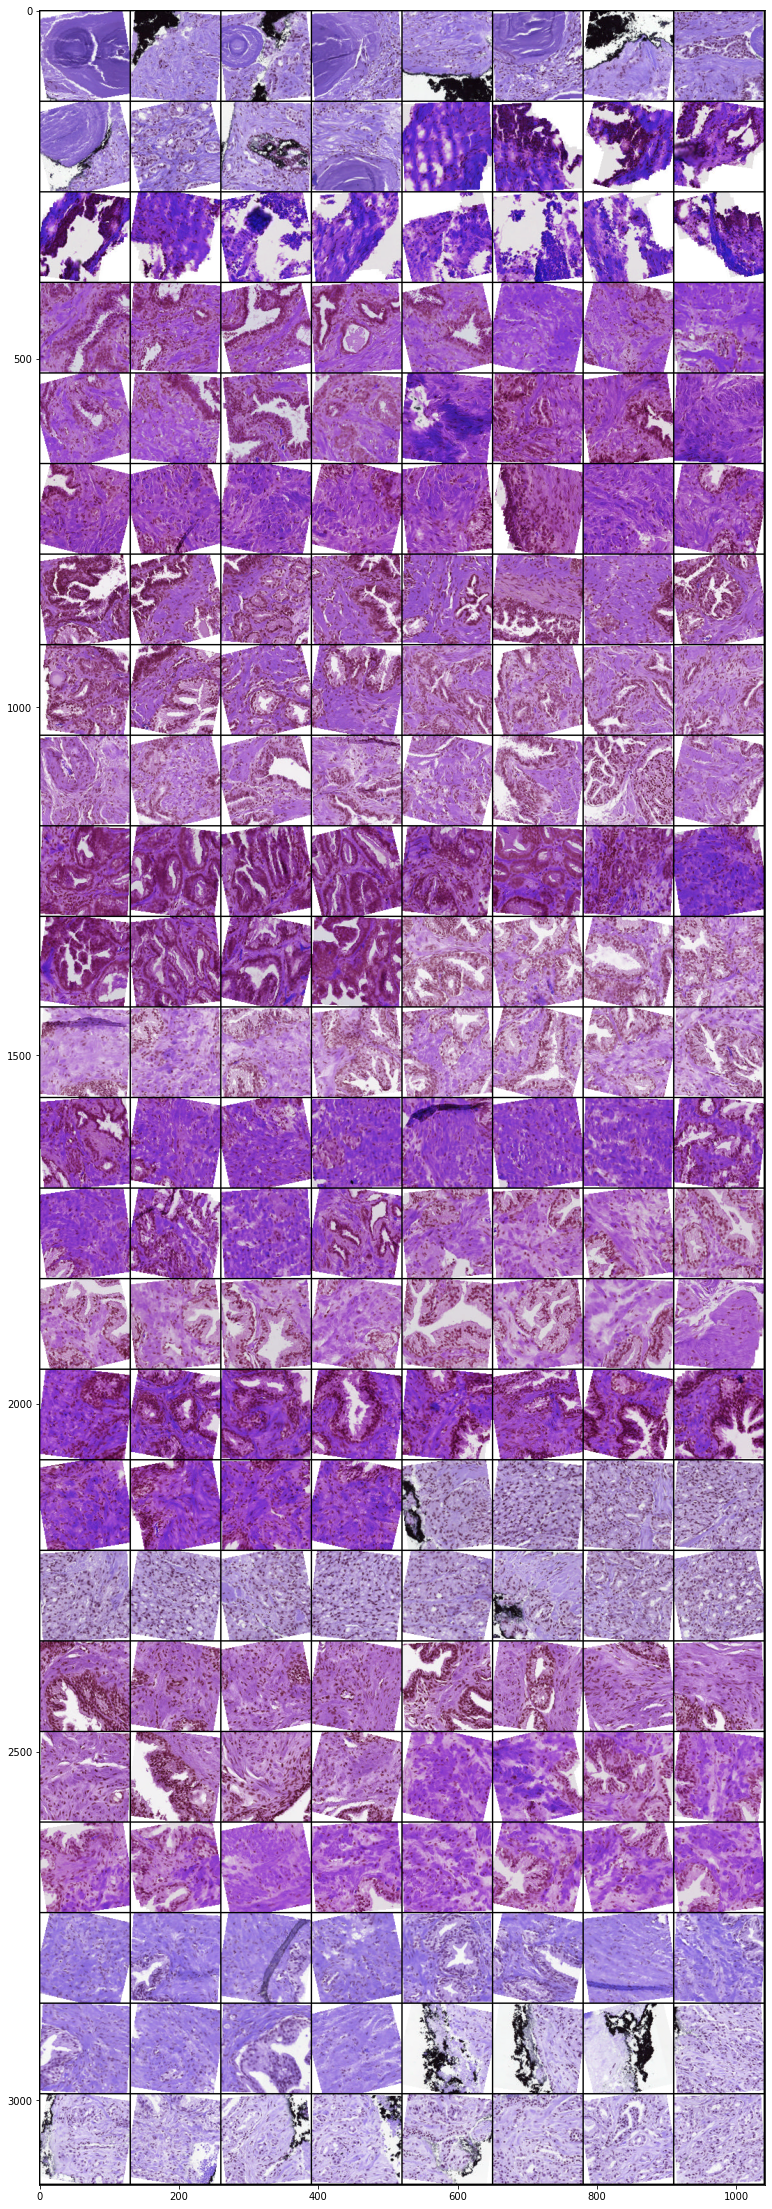

In [5]:
import torchvision
import matplotlib.pyplot as plt
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
plt.figure(figsize=(20,40))
images, labels = next(iter(model.trainloader))
images = images.reshape(-1, 3, 128, 128)
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", model.model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = 5,
    verbose = True,
    monitor = 'kappa_score/kappa_score',
    mode = 'max'
)

checkpoint_path

/home/kientiet/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50 exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


'/home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50'

In [7]:
tb_logger = loggers.TensorBoardLogger('logs/', name = model.model_name)
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                    nb_sanity_val_steps = 0, 
                    max_epochs = max_epoches, 
                    gpus = -1, 
                    logger = tb_logger)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning finder

In [8]:
# lr_finder = trainer.lr_find(model, min_lr = 1e-8, max_lr = 5., num_training = 200)

In [9]:
# fig = lr_finder.plot(suggest = True)

In [10]:
model.configure_optimizers()



>> Running with 1cycle scheduler


Lookahead (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0005
    lr: 0.0004999997256657939
    max_lr: 0.0005
    min_lr: 5e-06
    step_counter: 0
    weight_decay: 5e-05
)

## Start to train

In [11]:
trainer.fit(model)

INFO:lightning:
    | Name                             | Type              | Params
-------------------------------------------------------------------
0   | loss_func                        | CrossEntropyLoss  | 0     
1   | encoder                          | ResNetModel       | 23 M  
2   | encoder.encoder                  | Sequential        | 23 M  
3   | encoder.encoder.0                | Conv2d            | 9 K   
4   | encoder.encoder.1                | BatchNorm2d       | 128   
5   | encoder.encoder.2                | ReLU              | 0     
6   | encoder.encoder.3                | MaxPool2d         | 0     
7   | encoder.encoder.4                | Sequential        | 215 K 
8   | encoder.encoder.4.0              | Bottleneck        | 75 K  
9   | encoder.encoder.4.0.conv1        | Conv2d            | 4 K   
10  | encoder.encoder.4.0.bn1          | BatchNorm2d       | 128   
11  | encoder.encoder.4.0.conv2        | Conv2d            | 36 K  
12  | encoder.encoder.4.0.bn2   



>> Running with 1cycle scheduler
>> Return trainloader
>> Return valloader


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


INFO:lightning:
Epoch 00000: kappa_score/kappa_score reached 0.58253 (best 0.58253), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=0.ckpt as top 5


INFO:lightning:
Epoch 00001: kappa_score/kappa_score reached 0.68356 (best 0.68356), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=1.ckpt as top 5


INFO:lightning:
Epoch 00002: kappa_score/kappa_score reached 0.72778 (best 0.72778), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=2.ckpt as top 5


INFO:lightning:
Epoch 00003: kappa_score/kappa_score reached 0.69295 (best 0.72778), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=3.ckpt as top 5


INFO:lightning:
Epoch 00004: kappa_score/kappa_score reached 0.74119 (best 0.74119), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=4.ckpt as top 5




>> Running with 1cycle scheduler


INFO:lightning:
Epoch 00005: kappa_score/kappa_score reached 0.68516 (best 0.74119), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=5.ckpt as top 5


INFO:lightning:
Epoch 00006: kappa_score/kappa_score  was not in top 5


INFO:lightning:
Epoch 00007: kappa_score/kappa_score reached 0.74170 (best 0.74170), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=7.ckpt as top 5


INFO:lightning:
Epoch 00008: kappa_score/kappa_score reached 0.75472 (best 0.75472), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=8.ckpt as top 5


INFO:lightning:
Epoch 00009: kappa_score/kappa_score reached 0.78599 (best 0.78599), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=9.ckpt as top 5




>> Running with 1cycle scheduler


INFO:lightning:
Epoch 00010: kappa_score/kappa_score  was not in top 5


INFO:lightning:
Epoch 00011: kappa_score/kappa_score  was not in top 5


INFO:lightning:
Epoch 00012: kappa_score/kappa_score reached 0.75385 (best 0.78599), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=12.ckpt as top 5


INFO:lightning:
Epoch 00013: kappa_score/kappa_score reached 0.77492 (best 0.78599), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=13.ckpt as top 5


INFO:lightning:
Epoch 00014: kappa_score/kappa_score reached 0.81695 (best 0.81695), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50/epoch=14.ckpt as top 5


1

# Create the fixres

In [56]:
from trainer.supervised.baseline import BaselineTrainer
model = BaselineTrainer.load_from_checkpoint("checkpoint/baseline/resnet50/version3/epoch=14.ckpt")

>> Load from data frame


Using cache found in /home/kientiet/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder.0.weight
encoder.1.weight
encoder.1.bias
encoder.4.0.conv1.weight
encoder.4.0.bn1.weight
encoder.4.0.bn1.bias
encoder.4.0.conv2.weight
encoder.4.0.bn2.weight
encoder.4.0.bn2.bias
encoder.4.0.conv3.weight
encoder.4.0.bn3.weight
encoder.4.0.bn3.bias
encoder.4.0.downsample.0.weight
encoder.4.0.downsample.1.weight
encoder.4.0.downsample.1.bias
encoder.4.1.conv1.weight
encoder.4.1.bn1.weight
encoder.4.1.bn1.bias
encoder.4.1.conv2.weight
encoder.4.1.bn2.weight
encoder.4.1.bn2.bias
encoder.4.1.conv3.weight
encoder.4.1.bn3.weight
encoder.4.1.bn3.bias
encoder.4.2.conv1.weight
encoder.4.2.bn1.weight
encoder.4.2.bn1.bias
encoder.4.2.conv2.weight
encoder.4.2.bn2.weight
encoder.4.2.bn2.bias
encoder.4.2.conv3.weight
encoder.4.2.bn3.weight
encoder.4.2.bn3.bias
encoder.5.0.conv1.weight
encoder.5.0.bn1.weight
encoder.5.0.bn1.bias
encoder.5.0.conv2.weight
encoder.5.0.bn2.weight
encoder.5.0.bn2.bias
encoder.5.0.conv3.weight
encoder.5.0.bn3.weight
encoder.5.0.bn3.bias
encoder.5.0.downsample.0.weig

In [64]:
model.freeze_model()

>> Freeze all except batchnorm
>> Reload the dataset and dataloader
>> Config parameters
encoder.4.0.bn1.weight
encoder.4.0.bn1.bias
encoder.4.0.bn2.weight
encoder.4.0.bn2.bias
encoder.4.0.bn3.weight
encoder.4.0.bn3.bias
encoder.4.1.bn1.weight
encoder.4.1.bn1.bias
encoder.4.1.bn2.weight
encoder.4.1.bn2.bias
encoder.4.1.bn3.weight
encoder.4.1.bn3.bias
encoder.4.2.bn1.weight
encoder.4.2.bn1.bias
encoder.4.2.bn2.weight
encoder.4.2.bn2.bias
encoder.4.2.bn3.weight
encoder.4.2.bn3.bias
encoder.5.0.bn1.weight
encoder.5.0.bn1.bias
encoder.5.0.bn2.weight
encoder.5.0.bn2.bias
encoder.5.0.bn3.weight
encoder.5.0.bn3.bias
encoder.5.1.bn1.weight
encoder.5.1.bn1.bias
encoder.5.1.bn2.weight
encoder.5.1.bn2.bias
encoder.5.1.bn3.weight
encoder.5.1.bn3.bias
encoder.5.2.bn1.weight
encoder.5.2.bn1.bias
encoder.5.2.bn2.weight
encoder.5.2.bn2.bias
encoder.5.2.bn3.weight
encoder.5.2.bn3.bias
encoder.5.3.bn1.weight
encoder.5.3.bn1.bias
encoder.5.3.bn2.weight
encoder.5.3.bn2.bias
encoder.5.3.bn3.weight
encoder.